In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [154]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)
X = mushroom.data.features
y = mushroom.data.targets

target = y.columns[0]
features = list(X.columns)

In [155]:
df: pd.DataFrame = X.join(y)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [157]:
df.nunique()

cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   4
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
poisonous                    2
dtype: int64

In [158]:
df.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,...,9,9,1,4,3,5,9,6,7,2
top,x,y,n,f,n,f,c,b,b,t,...,w,w,p,w,o,p,w,v,d,e
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,...,4464,4384,8124,7924,7488,3968,2388,4040,3148,4208


In [159]:
features_to_drop = []

for c in X.columns:
    if X[c].nunique() == 1:
        features_to_drop.append(c)
        features.remove(c)

df.drop(features_to_drop, axis=1, inplace=True)
X = X.drop(features_to_drop, axis=1)

print(features_to_drop)

['veil-type']


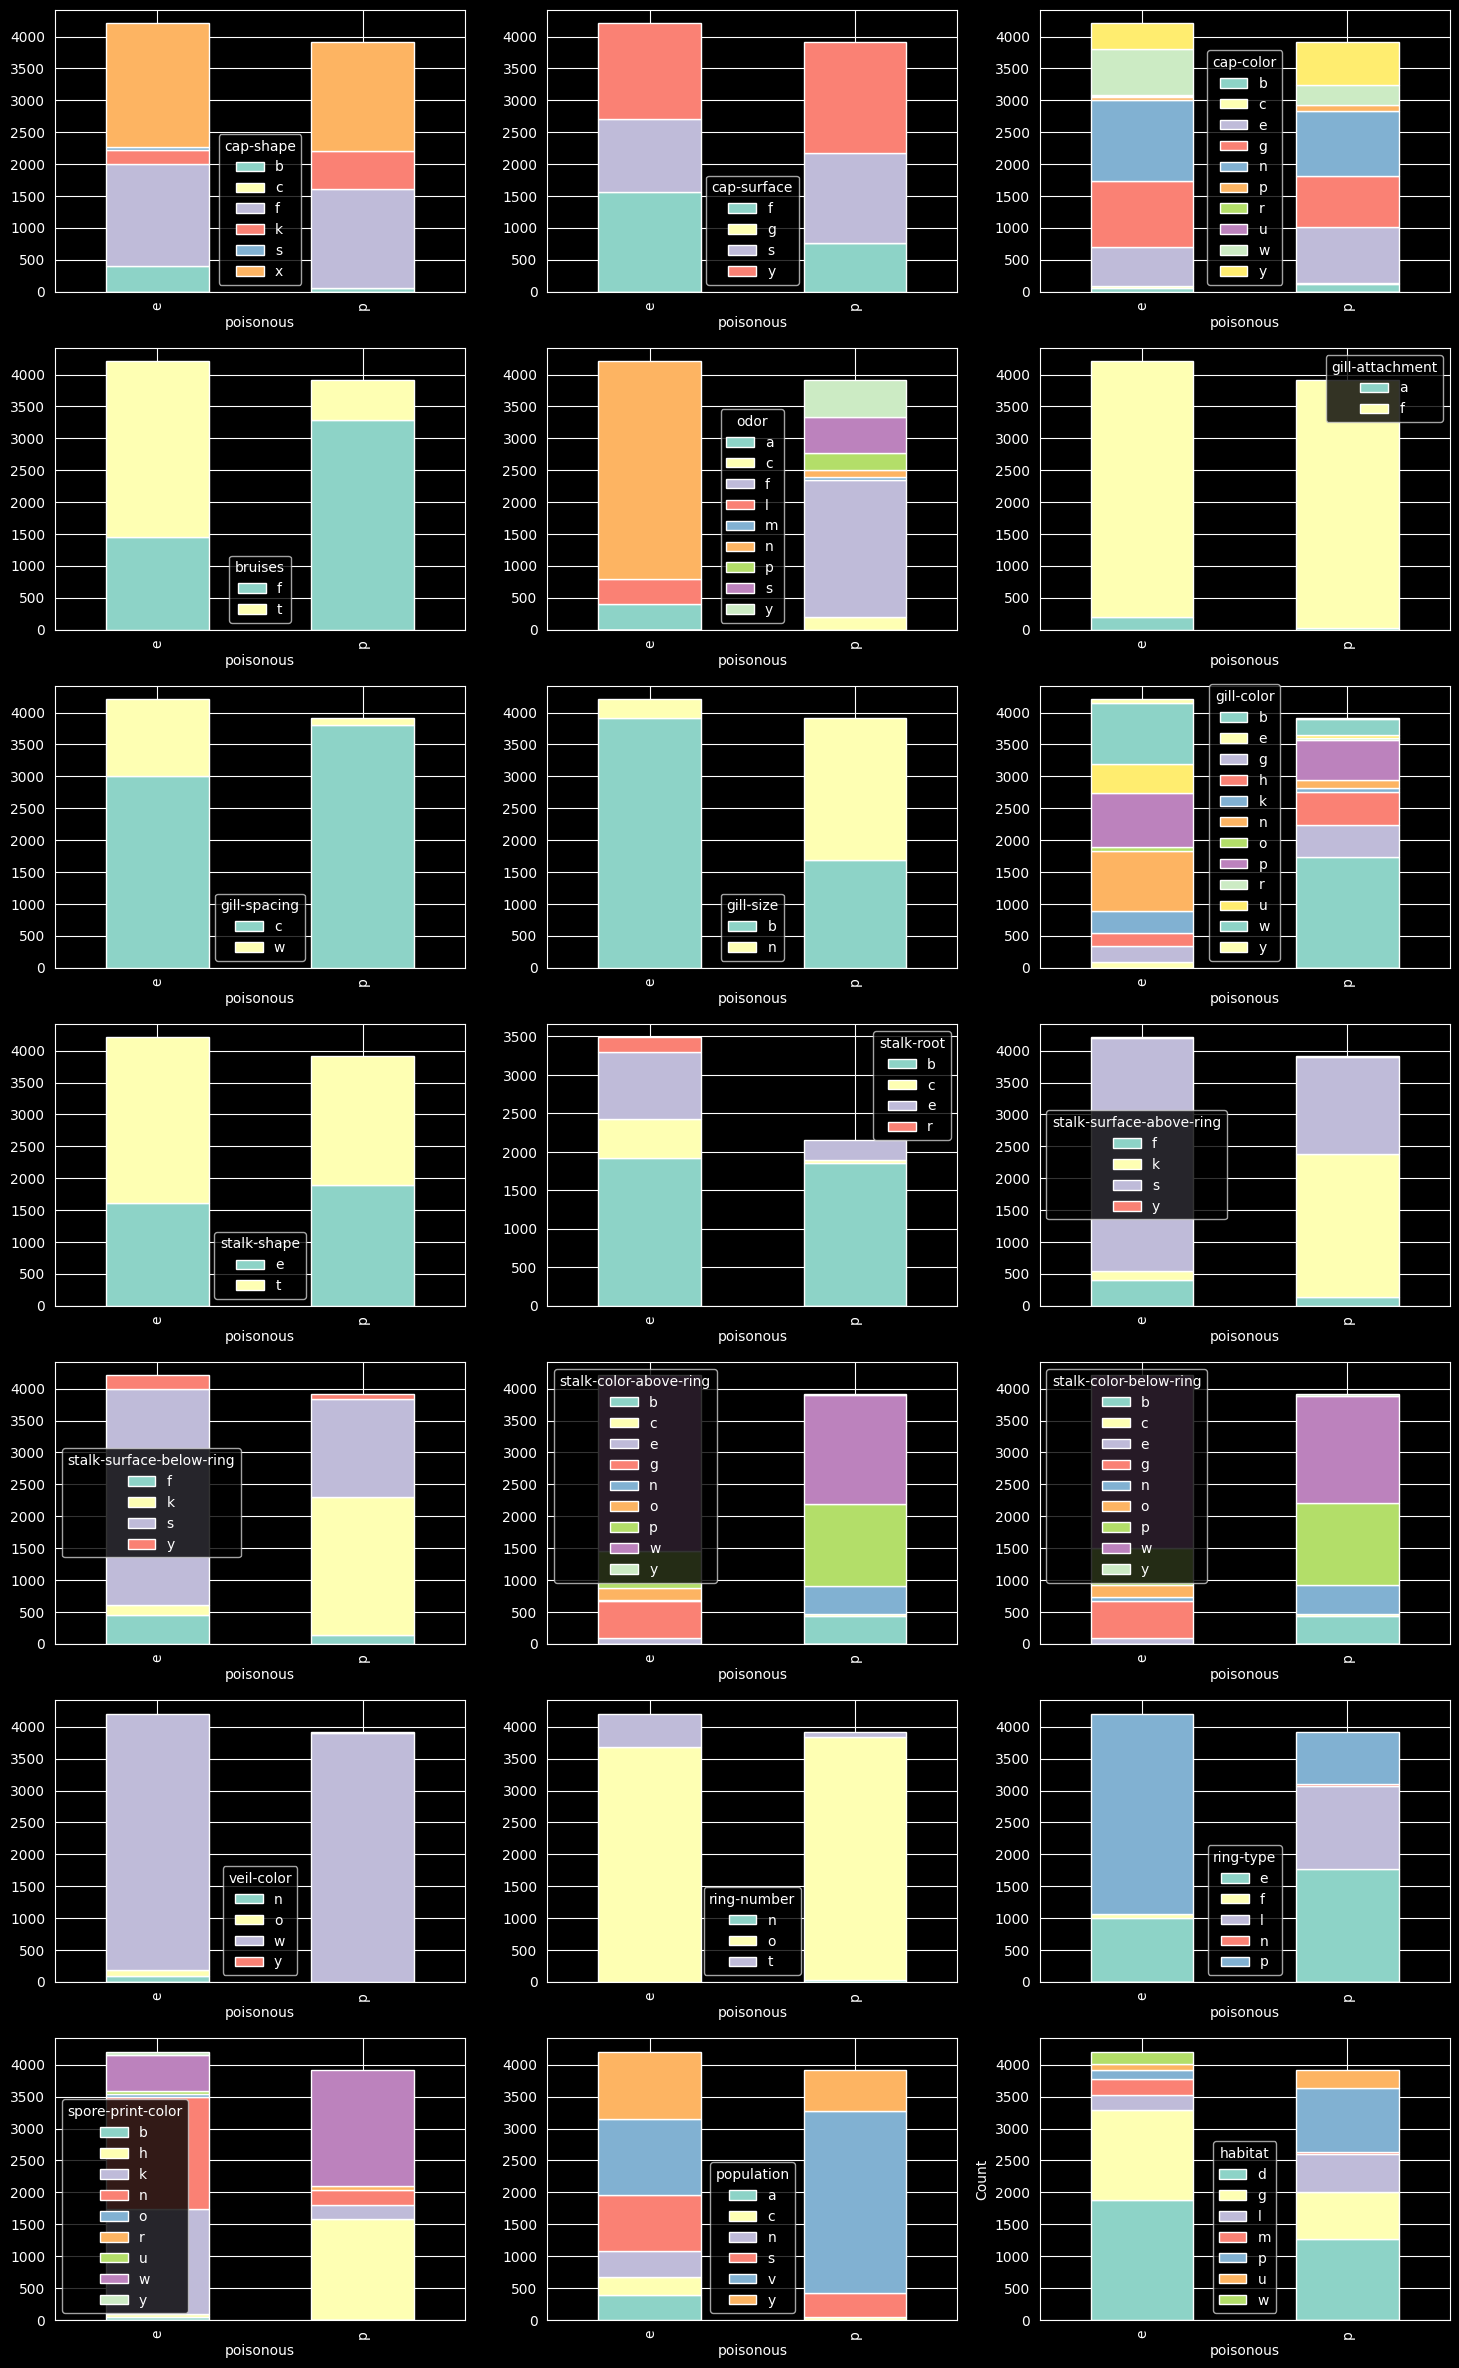

In [160]:
fig, sub = plt.subplots(7, 3, figsize=(18, 30))

for f, ax in zip(features, sub.flatten()):
    table = df.groupby([target, f]).size().unstack(fill_value=0)
    table.plot(kind="bar", stacked=True, ax=ax)
    plt.ylabel("Count")

plt.show()

In [161]:
from sklearn.preprocessing import LabelEncoder

for f in df.columns:
    le = LabelEncoder()
    f_values = df[f].values
    le.fit(f_values)
    df[f] = le.transform(f_values)

In [162]:
def get_unique_pairs(X, y) -> tuple[np.ndarray, np.ndarray]:
    pairs = np.column_stack((y, X))
    return np.unique(pairs, axis=0, return_counts=True)

In [163]:
from abc import ABC, abstractmethod

class MyBaseNB(ABC):
    @abstractmethod
    def fit(self, X, y) -> None:
        ...

    def predict_proba(self, X) -> np.ndarray:
        if not isinstance(X, np.ndarray):
            X = np.array([X])

        return np.array(list(map(self._get_proba, X)))

    def predict(self, X) -> np.ndarray:
        return self.predict_proba(X).argmax(axis=1)

    def score(self, X, y) -> float:
        if not isinstance(y, np.ndarray):
            y = np.array([y])

        if not isinstance(X, np.ndarray):
            X = np.array([X])
            x_size = 1
        else:
            x_size = X.shape[0]

        predictions = self.predict(X)

        return np.count_nonzero(predictions == y) / x_size

    @abstractmethod
    def _get_proba(self, x) -> np.ndarray:
        ...

In [164]:
class MySimpleNB(MyBaseNB):
    def __init__(self, feature: str, alpha = 1.0):
        self.__feature = feature
        self.__freqs = {}
        self.__classes = []
        self.__alpha = alpha

    def fit(self, X, y) -> None:
        self.__classes = np.unique(y).tolist()

        n_i = np.unique(X).size

        _, N_c = np.unique(y, return_counts=True)

        unique_pairs, pairs_count = get_unique_pairs(X, y)

        for i in range(n_i):
            self.__freqs[i] = {}
            for c in self.__classes:
                n_c = int(N_c[c])
                self.__freqs[i][c] = 1 / n_c * self.__alpha / (n_c + self.__alpha * n_i)

        for (c, i), count in zip(unique_pairs, pairs_count):
            c = int(c)
            i = int(i)
            count = int(count)
            n_c = int(N_c[c])
            self.__freqs[i][c] = 1 / n_c * (count + self.__alpha) / (n_c + self.__alpha * n_i)

    def _get_proba(self, x) -> np.ndarray:
        x = int(x)
        x_freqs = self.__freqs[x]

        probabilities = np.empty(len(self.__classes), dtype=float)

        for i, c in enumerate(self.__classes):
            probabilities[c] = x_freqs.get(c, 0)

        return probabilities / np.sum(probabilities)

    def __repr__(self) -> str:
        return f"MySimpleNB(feature={self.__feature}, alpha={self.__alpha})"

    @property
    def feature(self) -> str:
        return self.__feature

In [165]:
single_feature_scored_models = []

y_values = df[target].values
y_train = y_values
y_test = y_values

for f in features:
    model = MySimpleNB(feature=f, alpha=1)
    f_values = df[f].values
    X_train = f_values
    X_test = f_values
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    single_feature_scored_models.append((model, score))

for m, score in sorted(single_feature_scored_models, key=lambda x: x[1], reverse=True):
    print(f"{m.feature:<30}{round(score, 3)}")

odor                          0.985
spore-print-color             0.868
gill-color                    0.805
ring-type                     0.775
stalk-surface-above-ring      0.774
stalk-surface-below-ring      0.766
gill-size                     0.756
bruises                       0.744
population                    0.722
stalk-color-above-ring        0.716
stalk-color-below-ring        0.714
habitat                       0.69
stalk-root                    0.638
gill-spacing                  0.616
cap-color                     0.595
cap-surface                   0.581
stalk-shape                   0.553
ring-number                   0.538
cap-shape                     0.53
veil-color                    0.506
gill-attachment               0.503


In [166]:
class MyNB(MyBaseNB):
    def __init__(self, alpha = 1.0):
        self.__p_cit = None
        self.__p_c = None
        self.__n_classes = -1
        self.__n_features = -1
        self.__alpha = alpha

    def fit(self, X, y) -> None:
        self.__n_features = X.shape[1]
        self.__n_classes = len(np.unique(y))

        features_value_count = np.empty(self.__n_features, dtype=int)
        for i in range(self.__n_features):
            features_value_count[i] = np.unique(X[:, i]).size
        max_unique_feature_value_count = int(features_value_count.max())

        _, N_c = np.unique(y, return_counts=True)
        self.__p_c = N_c / N_c.sum()

        self.__p_cit = np.full(
            shape=(self.__n_classes, self.__n_features, max_unique_feature_value_count),
            fill_value=None
        )

        for i in range(self.__n_features):
            unique_pairs, pairs_count = get_unique_pairs(X[:, i], y)
            n_i = features_value_count[i]

            for y_value in range(self.__n_classes):
                n_c = N_c[y_value]
                self.__p_cit[y_value, i, :] = self.__alpha / (n_c + self.__alpha * n_i)

            for (y_value, x_value), n_tic in zip(unique_pairs, pairs_count):
                y_value = int(y_value)
                x_value = int(x_value)
                n_tic = int(n_tic)
                n_i = features_value_count[i]
                n_c = N_c[y_value]
                self.__p_cit[y_value, i, x_value] = (n_tic + self.__alpha) / (n_c + self.__alpha * n_i)

    def _get_proba(self, x) -> np.ndarray:
        result = np.empty(self.__n_classes, dtype=float)

        features_arange = np.arange(self.__n_features)
        for c in range(self.__n_classes):
            result[c] = self.__p_cit[c, features_arange, x].prod()

        return result * self.__p_c

    def __repr__(self) -> str:
        return f"MyNB(alpha={self.__alpha})"

In [167]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB, BernoulliNB

X_values = df.drop(target, axis=1).values

X_train = X_values
y_train = y_values

X_test = X_values
y_test = y_values

alpha = 1
models = [CategoricalNB(alpha=alpha), MyNB(alpha=alpha), GaussianNB(), MultinomialNB(), ComplementNB(), BernoulliNB()]

for m in models:
    m.fit(X_train, y_train)
    print(f"{str(m):<30}{m.score(X_test, y_test)}")

CategoricalNB(alpha=1)        0.9566715903495815
MyNB(alpha=1)                 0.9566715903495815
GaussianNB()                  0.9247907434761201
MultinomialNB()               0.7791728212703102
ComplementNB()                0.7800344657804037
BernoulliNB()                 0.879862136878385


In [168]:
def inverse_logit(X: np.ndarray) -> np.ndarray:
    return np.log(X / (1 - X))

X_lr = np.empty_like(X_values, dtype=float)
for i, (m, _) in enumerate(single_feature_scored_models):
    f = m.feature
    f_probas = m.predict_proba(df[f].values)[:, 0]
    X_lr[:, i] = inverse_logit(f_probas)

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_lr,
    y_values,
    test_size=0.3,
    random_state=42
)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

